# Main of the paper - LSR - $\sigma \neq 0.4$

In this notebook are gathered all experiments generated for the main of the paper using a least-squares regression which require presence of noise.

In [1]:
# Add below current directory to path
# Notebook cannot import any code without this line !!!!
import sys; sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import IntSlider, interact
from math import sqrt

from tqdm import tqdm, trange # For progress bar
%matplotlib inline
%load_ext autoreload
%autoreload 2

from src.models.CostModel import RMSEModel, build_several_cost_model

from src.machinery.GradientDescent import ArtemisDescent, DianaDescent, FL_VanillaSGD
from src.machinery.Parameters import *
from src.machinery.PredefinedParameters import *

from src.utils.ErrorPlotter import *
from src.utils.Constants import *
from src.utils.DataPreparation import build_data_linear, add_bias_term
from src.utils.Utilities import pickle_loader, pickle_saver
from src.utils.runner.RunnerUtilities import *
from src.utils.runner.ResultsOfSeveralDescents import ResultsOfSeveralDescents

filename = "with_noise"

nb_devices_for_the_run = 10
dim_notebook = 20
MAX_NB_DEVICES = 40

In [2]:
# Building data
w_true = generate_param(dim_notebook)
X, Y = build_data_linear(w_true, n_dimensions = dim_notebook, 
                         n_devices=MAX_NB_DEVICES, with_seed=False, without_noise=False)
X = add_bias_term(X)
print(X[0].shape)
pickle_saver((X, Y), filename + "-data")

torch.Size([200, 21])


Text(0.5, 1.0, 'Model weights')

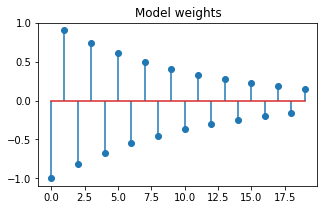

In [3]:
plt.figure(figsize=(5, 3))
plt.stem(w_true, use_line_collection=True)
plt.title("Model weights")

In [4]:
# Creating cost models which will be used to computed cost/loss, gradients, L ...
cost_models = build_several_cost_model(RMSEModel, X, Y, nb_devices_for_the_run)

In [5]:
%%time
obj_min_by_N_descent = FL_VanillaSGD(Parameters(n_dimensions = dim_notebook + 1, 
                                                     nb_devices=nb_devices_for_the_run,
                                                     nb_epoch=1000, 
                                                     momentum=0., 
                                                     quantization_param=0,
                                                     verbose=True, 
                                                     cost_models=cost_models,
                                                     stochastic=False,
                                                     bidirectional=False,
                                                    ))
obj_min_by_N_descent.run(cost_models)
obj_min_by_N = obj_min_by_N_descent.losses[-1]
pickle_saver(obj_min_by_N, filename + "-obj_min")

   it    |   obj   
     200 | 8.2389e-02
     400 | 8.2389e-02
     600 | 8.2389e-02
     800 | 8.2389e-02
Gradient Descent: execution time=1.645 seconds
Final loss : 0.08239

CPU times: user 2.18 s, sys: 28.4 ms, total: 2.2 s
Wall time: 1.65 s


In [6]:
obj_min_by_N_descent.model_params[-1]

tensor([ 2.0178, -0.9913,  0.8935, -0.8127,  0.7613, -0.6821,  0.6076, -0.5566,
         0.4946, -0.4434,  0.4035, -0.3716,  0.3323, -0.2976,  0.2819, -0.2423,
         0.2164, -0.1863,  0.1743, -0.1709,  0.1526], dtype=torch.float64)

In [7]:
%%time
all_descent = {}
for type_params in tqdm(KIND_COMPRESSION):
    multiple_sg_descent = multiple_run_descent(type_params, cost_models=cost_models)
    all_descent[type_params.name()] = multiple_sg_descent
res = ResultsOfSeveralDescents(all_descent, nb_devices_for_the_run)
pickle_saver(res, filename + "-descent")

  0%|          | 0/5 [00:00<?, ?it/s]

SGD


 20%|██        | 1/5 [00:29<01:58, 29.62s/it]

QSGD


 40%|████      | 2/5 [01:41<02:06, 42.17s/it]

Diana


 60%|██████    | 3/5 [02:45<01:37, 48.81s/it]

BiQSGD


 80%|████████  | 4/5 [03:53<00:54, 54.71s/it]

Artemis


100%|██████████| 5/5 [05:01<00:00, 60.38s/it]

CPU times: user 5min 1s, sys: 68.1 ms, total: 5min 1s
Wall time: 5min 1s


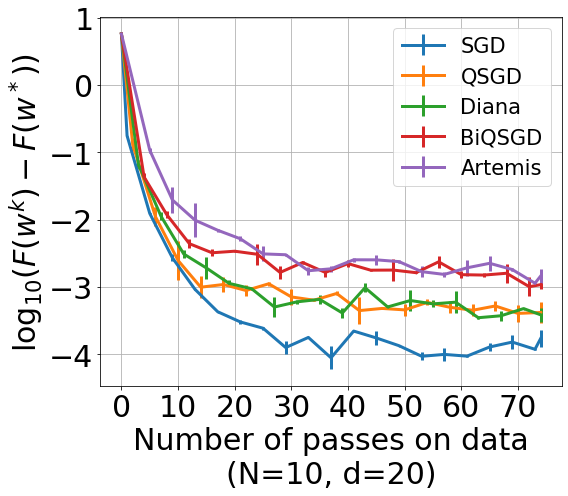

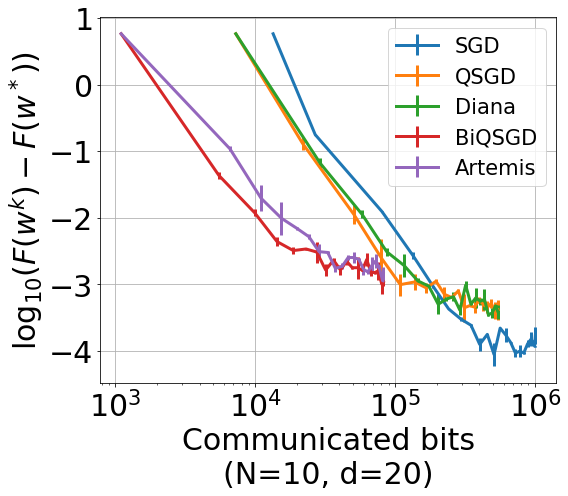

In [8]:
obj = pickle_loader(filename + "-obj_min")
res = pickle_loader(filename + "-descent")

plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook,
               all_error=res.get_std(obj)) 
plot_error_dist(res.get_loss(obj), res.names, res.nb_devices_for_the_run, dim_notebook, 
                x_points=res.X_number_of_bits, x_legend="Communicated bits", all_error=res.get_std(obj))  
